In [2]:
# LIBRERIAS E INSTALACIONES QUE NO TENIA (CREO QUE NO ES NECESARIO QUE LO CORRAN)
pkgs = {
    "matplotlib":       "matplotlib",
    "numpy":            "numpy",
    "pandas":           "pandas",
    "scipy":            "scipy",
    "skimage":          "scikit-image",   # el módulo es skimage, pero pip lo llama scikit-image
    "histomicstk":      "histomicstk",
    "openslide":        "openslide-python"
}

import importlib, subprocess, sys

for module_name, pip_name in pkgs.items():
    try:
        importlib.import_module(module_name)
    except ImportError:
        print(f"→ Instalando `{pip_name}` para poder usar `import {module_name}`…")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name])
        # tras instalar, volvemos a importar
        importlib.import_module(module_name)



In [3]:
#LIBRERIAS 
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import histomicstk as htk
from scipy import ndimage as ndi
from skimage.io import imread
from skimage.color import label2rgb
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_objects, dilation
from skimage.segmentation import watershed
from skimage.measure import label, regionprops
from skimage.measure import regionprops_table

In [4]:
#DE RGB-->OD
import numpy as np
import cv2
import matplotlib.pyplot as plt

def rgb2od(img_rgb):
    """
    Convierte una imagen RGB (0–255) a absorbancia (densidad óptica).
    """
    # convertir a float, evitar log(0) sumando 1, normalizar /256
    img = img_rgb.astype(np.float32) + 1.0
    od = -np.log10(img / 256.0)
    return od


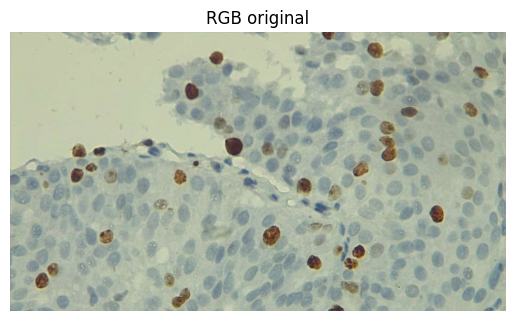

In [5]:
# CARGAR LA IMAGEN 
ruta = r"G:\Mi unidad\Niki Facultad\DIGPATHO\EZE004 (5) (1).jpg"#--> PONER LA DIRECCION DE DONDE TIENEN GUARDADA LA IMAGEN 
rgb = cv2.imread(ruta)           # OpenCV carga en BGR
rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)  # convertimos a RGB
plt.imshow(rgb)
plt.title("RGB original")
plt.axis("off")
plt.show()


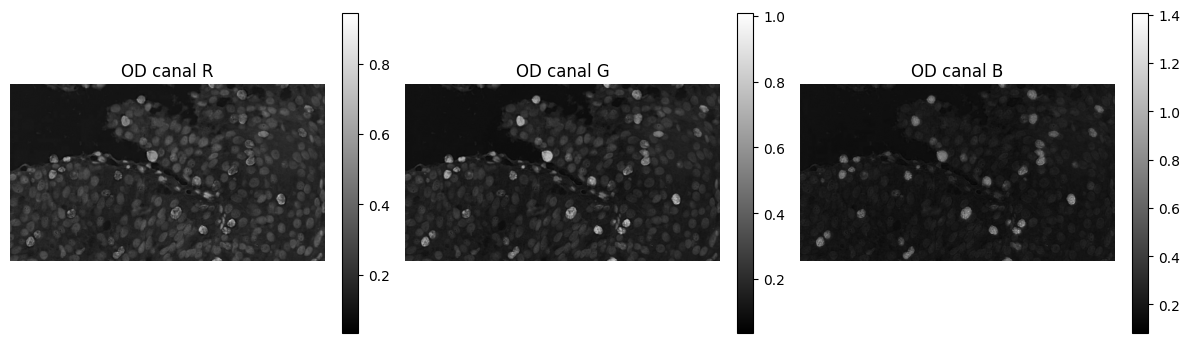

In [ ]:
#3) Convertir a Densidad Óptica
od = rgb2od(rgb)
# Visualicemos cada canal OD:
fig, axes = plt.subplots(1,3, figsize=(12,4))
for i, nombre in enumerate(["R","G","B"]):
    ax = axes[i]
    im = ax.imshow(od[:,:,i], cmap="gray")
    ax.set_title(f"OD canal {nombre}")
    ax.axis("off")
    fig.colorbar(im, ax=ax, fraction=0.046)
plt.tight_layout()
#DE ACA IDENTIFIQUE QUE EL CANAL g ES EL QUE MEJOR SEPARa el fondo 

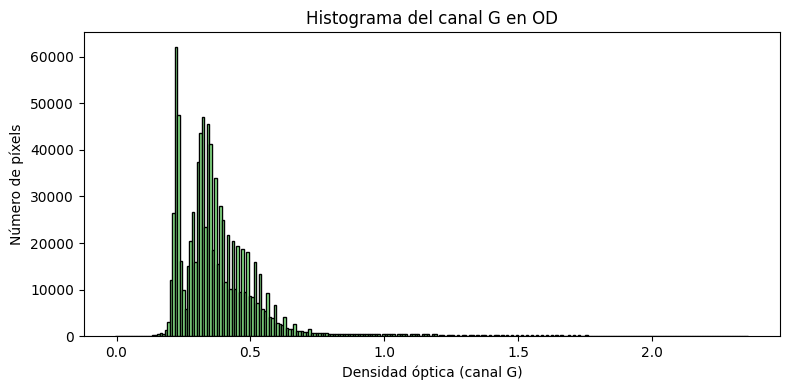

In [7]:
#-------------HISTOGRAMA CANAL G (fondo)-------------------
# Convertimos a densidad óptica y extraemos el canal G
I = rgb.astype(np.float64) / 255.0
od = -np.log(I + 1e-6)
G_od = od[:, :, 1]    # segundo plano, el “canal G” en OD

# Calculamos y dibujamos su histograma
hist, bins = np.histogram(G_od.ravel(), bins=256, range=(0, G_od.max()))

plt.figure(figsize=(8,4))
plt.bar(bins[:-1], hist, width=bins[1]-bins[0], color='lightgreen', edgecolor='black')
plt.title("Histograma del canal G en OD")
plt.xlabel("Densidad óptica (canal G)")
plt.ylabel("Número de píxels")
plt.tight_layout()
plt.show()

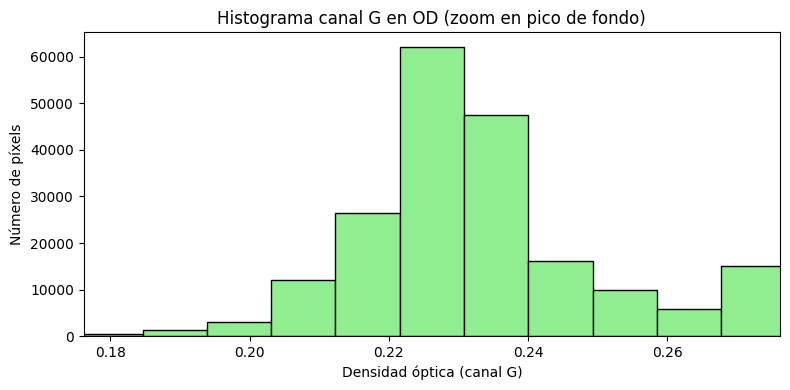

Pico máximo en OD canal G ≃ 0.226


In [8]:
# Calculamos el bin central de la barra más alta
bin_centers = (bins[:-1] + bins[1:]) / 2
max_idx    = np.argmax(hist)
peak_val   = bin_centers[max_idx]

# Definimos un intervalo alrededor del pico, p. ej. ±0.05 OD
delta = 0.05
x_min = max(0, peak_val - delta)
x_max = peak_val + delta

# Volvemos a dibujar el histograma con zoom
plt.figure(figsize=(8,4))
plt.bar(bin_centers, hist, width=bins[1]-bins[0], color='lightgreen', edgecolor='black')
plt.title("Histograma canal G en OD (zoom en pico de fondo)")
plt.xlabel("Densidad óptica (canal G)")
plt.ylabel("Número de píxels")
plt.xlim(x_min, x_max)
plt.tight_layout()
plt.show()

print(f"Pico máximo en OD canal G ≃ {peak_val:.3f}")


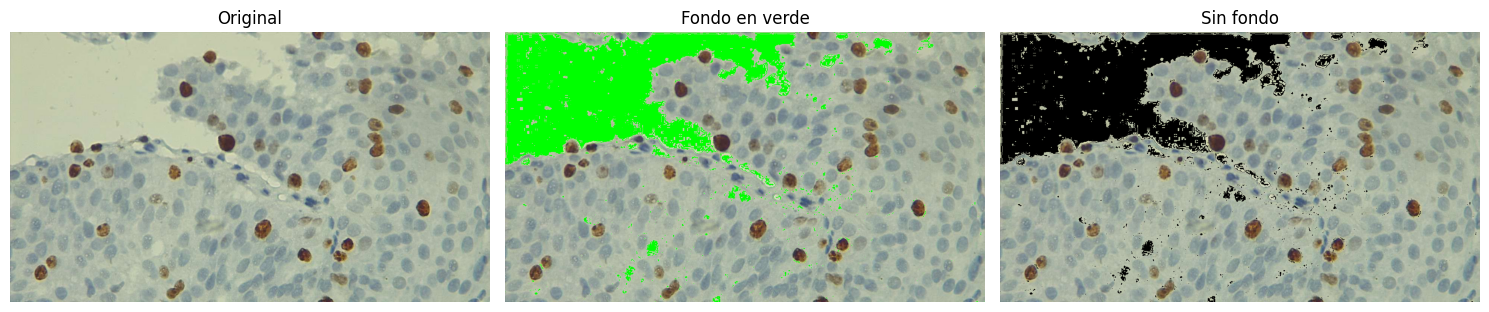

In [14]:
# -------------------------------------------------------
# 1) Definimos una tolerancia alrededor del pico para capturar bien el fondo
delta = 0.02
threshold_low  = peak_val - delta
threshold_high = peak_val + delta

# 2) Creamos la máscara de fondo
bg_mask = (G_od >= threshold_low) & (G_od <= threshold_high)

# 3) Pintamos ese fondo de verde
overlay_bg = rgb.copy()
overlay_bg[bg_mask] = [0,255,0]

# 4) “Eliminamos” el fondo poniendo esos píxeles a negro
no_bg = rgb.copy()
no_bg[bg_mask] = [0,0,0]

# 5) Mostramos todo lado a lado
fig, axes = plt.subplots(1,3, figsize=(15,5))

axes[0].imshow(rgb)
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(overlay_bg)
axes[1].set_title("Fondo en verde")
axes[1].axis("off")

axes[2].imshow(no_bg)
axes[2].set_title("Sin fondo")
axes[2].axis("off")

plt.tight_layout()
plt.show()


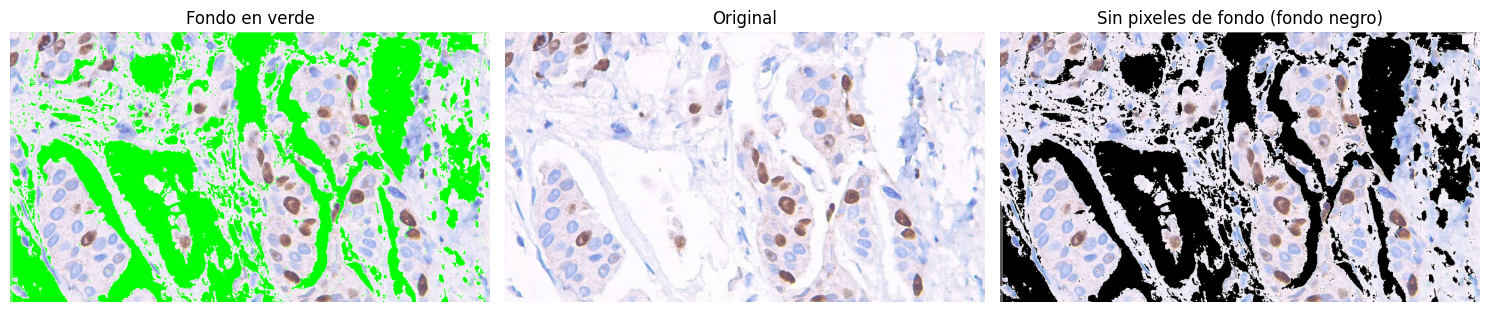

In [24]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1) Ruta de la nueva imagen
ruta = r"G:\Mi unidad\Niki Facultad\DIGPATHO\IMEGENES\EZE020 (8) (P).jpg"

# 2) Cargo y convierto de BGR a RGB
bgr = cv2.imread(ruta)
if bgr is None:
    raise FileNotFoundError(f"No se encontró el archivo: {ruta}")
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

# 3) Paso a densidad óptica (OD)
I  = rgb.astype(np.float64) / 255.0
od = -np.log(I + 1e-6)

# 4) Extraigo el canal G en OD (el que mejor separa fondo vs. señal)
G_od = od[:, :, 1]

# 5) Histograma y pico de fondo
hist, bins = np.histogram(G_od.ravel(), bins=256, range=(0, G_od.max()))
peak_idx = hist.argmax()
peak_val = (bins[peak_idx] + bins[peak_idx+1]) / 2

# 6) Umbral respecto al pico de fondo
delta     = 0.02
threshold = peak_val + delta

# 7) Máscara de POSITIVOS (donde G_od > threshold)
mask_pos = G_od > threshold

# 8) Máscara de FONDO (inversa)
mask_bg = ~mask_pos

# 9) Overlay: Pinto el FONDO de verde
overlay_bg = rgb.copy()
overlay_bg[mask_bg] = [0, 255, 0]

# 10) Imagen “sin fondo” (fondo en negro)
only_pos = rgb.copy()
only_pos[mask_bg] = [0, 0, 0]

# 11) Muestro lado a lado
fig, axs = plt.subplots(1, 3, figsize=(15, 5))



axs[0].imshow(overlay_bg)
axs[0].set_title("Fondo en verde")
axs[0].axis("off")

axs[1].imshow(rgb)
axs[1].set_title("Original")
axs[1].axis("off")

axs[2].imshow(only_pos)
axs[2].set_title("Sin pixeles de fondo (fondo negro)")
axs[2].axis("off")

plt.tight_layout()
plt.show()



In [1]:
from PIL import Image

# 1. Abre la imagen
img = Image.open("D:\Downloads\WhatsApp Image 2025-06-26 at 7.26.59 PM.jpeg")

# 2. Define el nuevo tamaño (ancho, alto) en píxeles
nuevo_tamano = (1500, 1000)  # por ejemplo 800 px de ancho y 600 px de alto

# 3. Redimensiona la imagen
img_redimensionada = img.resize(nuevo_tamano, resample=Image.LANCZOS)

# 4. Guarda el resultado
img_redimensionada.save("D:\Downloads\documen.jpeg")


<>:4: SyntaxWarning: invalid escape sequence '\D'
<>:13: SyntaxWarning: invalid escape sequence '\D'
<>:4: SyntaxWarning: invalid escape sequence '\D'
<>:13: SyntaxWarning: invalid escape sequence '\D'
C:\test\ipykernel_4896\1867423258.py:4: SyntaxWarning: invalid escape sequence '\D'
  img = Image.open("D:\Downloads\WhatsApp Image 2025-06-26 at 7.26.59 PM.jpeg")
C:\test\ipykernel_4896\1867423258.py:13: SyntaxWarning: invalid escape sequence '\D'
  img_redimensionada.save("D:\Downloads\documen.jpeg")
